In [2]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
# from torchvision import datasets

# This is PyTorch Example
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# This is my example
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, images, labels=None):
        self.X = images
        self.y = labels
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert('RGB')
        # image = self.aug(image=np.array(image))['image']
        # image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = np.transpose(image, (0, 1, 2)).astype(np.float32)/255
        label = self.y[i]
        return {
            'image': torch.tensor(image, dtype=torch.float), 
            'target': torch.tensor(label, dtype=torch.long)
        }

    # def preprocess_image(self, image):
    #     image = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    #     image = torch.tensor(im).permute(2,0,1)
    #     image = self.normalize(im/255.)
    #     return im[None]

In [19]:
from torchvision import transforms
preprocess = transforms.Compose([
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Path of the dataset
PATH = "../data/CelebFaces/"
# Normalization parameters for pre-trained PyTorch models
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
# high res. image
IMG_SHAPE = (256, 256)
# computation device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCH = 5

In [4]:
# Split Train and Testing Dataset
# 下面展示如何拆分图像数据集
from sklearn.model_selection import train_test_split
# import glob
# train_paths, test_paths = train_test_split(sorted(glob.glob(PATH + "/*.*")), 
#                                             test_size=0.02, random_state=42)

# train_paths

# train_ds = ImageDataset(train_paths, hr_shape=IMG_SHAPE)
# test_ds  = ImageDataset(test_paths, hr_shape=IMG_SHAPE)

df = pd.read_csv(PATH+'CF100.csv')
X = PATH + 'img/' + df.image_id.values # image paths
y = df.Male.values # targets
(X_train, X_test, y_train, y_test) = train_test_split(X, y,	test_size=0.2, random_state=42)
# train_data = ImageDataset(xtrain, ytrain, tfms=1)
# test_data = ImageDataset(xtest, ytest, tfms=0)

X_train


array(['../data/CelebFaces/img/000056.jpg',
       '../data/CelebFaces/img/000089.jpg',
       '../data/CelebFaces/img/000027.jpg',
       '../data/CelebFaces/img/000043.jpg',
       '../data/CelebFaces/img/000070.jpg',
       '../data/CelebFaces/img/000016.jpg',
       '../data/CelebFaces/img/000041.jpg',
       '../data/CelebFaces/img/000097.jpg',
       '../data/CelebFaces/img/000010.jpg',
       '../data/CelebFaces/img/000073.jpg',
       '../data/CelebFaces/img/000012.jpg',
       '../data/CelebFaces/img/000048.jpg',
       '../data/CelebFaces/img/000086.jpg',
       '../data/CelebFaces/img/000029.jpg',
       '../data/CelebFaces/img/000094.jpg',
       '../data/CelebFaces/img/000006.jpg',
       '../data/CelebFaces/img/000067.jpg',
       '../data/CelebFaces/img/000066.jpg',
       '../data/CelebFaces/img/000036.jpg',
       '../data/CelebFaces/img/000017.jpg',
       '../data/CelebFaces/img/000050.jpg',
       '../data/CelebFaces/img/000035.jpg',
       '../data/CelebFaces/img/0

## 下面几段代码演示如何显示原始图片

In [5]:
from PIL import Image
img = Image.open(X_train[0])  
img.show()

In [6]:
# 这种方法有点小问题
# import cv2
# img = cv2.imread(X_train[1],0)
# cv2.imshow(X_train[1],img)

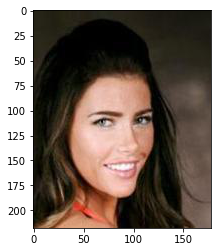

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(X_train[2])
imgplot = plt.imshow(img)
plt.show()

In [8]:
# import matplotlib.pyplot as plt
# img_sample = X_train[0]
# plt.imshow(img_sample, cmap="gray")
# plt.show()

## 下面显示如何显示像素点格式的图片对象

In [20]:
train_ds = ImageDataset(X_train, y_train)
test_ds = ImageDataset(X_test, y_test)

print(type(train_ds)) 
# img = train_data[1]['image'].squeeze()/255 # 果然，除以255之后就都好了！
img = train_ds[1]['image'] # 不用Squeeze也可以呀，第一个[1]是选择第一个元素，第二个是选择集合中的['image']字段
plt.imshow(img) # 此时再次显示图片，不需要imread环节了
plt.show()
img 

TypeError: __init__() got an unexpected keyword argument 'transform'

## 下面要显示DataLoader的用法

<class 'dict'>
Feature batch shape: torch.Size([64, 218, 178, 3])
Labels batch shape: torch.Size([64])


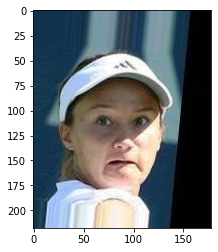

Label: -1


In [10]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Display image and label.
data_samples = next(iter(train_dl))
print(type(data_samples)) # 类型从DS变成了字典Array，结构有所不同了
print(f"Feature batch shape: {data_samples['image'].size()}")
print(f"Labels batch shape: {data_samples['target'].size()}")
img = data_samples['image'][3] # 注意了，此时的方框顺序完全反过来了
# img = data_samples[0][3] # 不可以这样用，不是张量，是集合
lbl = data_samples['target'][3]
plt.imshow(img)
plt.show()
print(f"Label: {lbl}")

## 下面要创建一个简单的模型了

In [14]:
# import pretrainedmodels
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

# 这是迁移学习的一种方法
# # Just choose any module to train
# class ResNet50(nn.Module):
#     def __init__(self, pretrained, requires_grad):
#         super(ResNet50, self).__init__()
#         if pretrained is True:
#             self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
#         else:
#             self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
            
#         if requires_grad == True:
#             for param in self.model.parameters():
#                 param.requires_grad = True
#         elif requires_grad == False:
#             for param in self.model.parameters():
#                 param.requires_grad = False
        
#         self.l0 = nn.Linear(2048, 256)

#     def forward(self, x):
#         batch, _, _, _ = x.shape
#         x = self.model.features(x)
#         x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
#         l0 = self.l0(x)
#         return l0


# Get pretrained model using torchvision.models as models library
# model = models.densenet161(pretrained=True)
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False


# Create new classifier for model using torch.nn as nn library
# https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7
classifier_input = model.classifier.in_features
num_labels = 2 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
model.classifier = classifier

# model = nn.Sequential(
#             nn.Linear(218 * 178, 1000),
#             nn.ReLU(),
#             nn.Linear(1000, 2)
#         ).to(DEVICE))

# model = ResNet50(pretrained=True, requires_grad=False)
model.to(DEVICE)

# optimizer - 优化器
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.Adam(model.classifier.parameters())
# loss function - 损失函数
criterion = nn.CrossEntropyLoss()

# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} trainable parameters.")

29,259,842 total parameters.
2,787,842 trainable parameters.


In [18]:
classifier_input

2208

In [15]:
# 创建一个fit函数

from tqdm import tqdm # 进度条工具
# training function
def fit(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data['image'].to(device), data['target'].to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
            
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy

# 创建一个validation函数

# validation function
def validate(model, dataloader, optimizer, criterion, val_data, device):
    print('Validating')
        
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data['image'].to(device), data['target'].to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
        return val_loss, val_accuracy

## 训练并验证模型

In [17]:
import time
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
    
start = time.time()
for epoch in range(EPOCH):
    print(f"Epoch {EPOCH+1} of {EPOCH}")
    train_epoch_loss, train_epoch_accuracy = fit(model, train_dl, 
                                                 optimizer, criterion, 
                                                 X_train, DEVICE)
    val_epoch_loss, val_epoch_accuracy = validate(model, valid_dl, 
                                                 optimizer, criterion, 
                                                 X_test, DEVICE)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()

print(f"Took {((end-start)/60):.3f} minutes to train for {EPOCH} epochs")


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 of 5
Training


  0%|          | 0/1 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [96, 3, 7, 7], expected input[64, 218, 178, 3] to have 3 channels, but got 218 channels instead